In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import asyncio
from functools import wraps
import openai
from faker import Faker
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../privacypromptrewriting')
from utils import *
from tqdm.auto import tqdmfrom pyfpe_ff3 import FF3Cipher

In [15]:
import openai
openai.api_key = "SECRET_KEY"

N = {'bmi': 45} 
epsilon = [.1,.5,1,2]

num_runs= 10
key = "EF4359D8D580AA4F7F036D6F04FC6A94"
tweak = "D8E7920AFA330A73" 
c = FF3Cipher(key, tweak,allow_small_domain=True, radix=10)

In [16]:
import asyncio
from functools import wraps
async def query_llm(text,system_text):
    response = openai.ChatCompletion.create(
              model='gpt-4-1106-preview',
              messages=[
                {
                  "role": "system",
                  "content": system_text
                },
                {
                  "role": "user",
                  "content": text 
                },
              ],
              temperature=0,
              max_tokens=5,
              top_p=.3,
              frequency_penalty=0,
              presence_penalty=0
            )
    return response
def retry(exceptions, tries=3, delay=1):
    def decorator(func):
        @wraps(func)
        async def wrapper(*args, **kwargs):
            current_tries = 0
            while current_tries < tries:
                try:
                    return await func(*args, **kwargs)
                except exceptions as e:
                    print(f"Exception caught: {e}")
                    await asyncio.sleep(delay)
                    current_tries += 1
            raise Exception("Max retries exceeded, failed to execute function.")

        return wrapper

    return decorator

# Applying retry decorator to handle 502 Bad Gateway
@retry(Exception, tries=3, delay=1)
async def query_with_retry(text,system_text):
    return await query_llm(text,system_text)

In [9]:
# Template:
# Jon Smith is a 50 year old man, with bmi 24, blood pressure of 120/80mmHG, heart rate of 60bpm, and temperature of 36.6 degrees celsius. 
# Is the patient healthy and based on the vitals what concerns should be raised to their physician?

# vital statistics
bmis = [20, 25, 30, 45]
bp_systoles = [100, 120, 130, 140]
bp_diastoles = [60, 80, 90, 100]
heart_rates = [60, 75, 90, 120]
ages = [15, 30, 55, 70]

In [7]:
# Create a 2 by 2 figure plot
# Data is already cached in datasets/med-qa
"""
Experiment 1: Only varying BMI.
"""
output_dataset = np.zeros((num_runs,len(bmis),len(epsilon)))
age_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
bmi_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
bp_sys_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
bp_dia_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
heart_rate_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
system_text = "You are a medical assistant that answers questions from a user about their health based on their vitals with either 'Yes' or 'No'. For example, 'User: Jon Smith is a 50 year old man, with bmi 24, blood pressure of 120/80mmHG and heart rate of 60bpm. Is the patient healthy based on their vitals?. Assistant: '"

for i, bmi in tqdm(zip(range(len(bmis)), bmis), total=len(bmis)):
#     text = f'User: Jon Smith is a {age} year old man, with bmi {bmi}, blood pressure of {bp_sys}/{bp_dia}mmHG and heart rate of {heart_rate}bpm. Is the patient healthy based on their vitals?. Assistant: '                        
    text = f'User: Jon Smith is a 30 year old man, with bmi {bmi}, blood pressure of 120/80mmHG and heart rate of 60bpm. Is the patient healthy based on their vitals?. Assistant: '                        
    entities = extract_entities_regex(text, fields=['bmi'])

    for j in range(len(epsilon)):
        output_fraction = []
        outputs = []
        inputs = []
        age_inputs = []
        bmi_inputs = []
        bp_sys_inputs = []
        bp_dia_inputs = []
        heart_rate_inputs = []
        
        for k in range(num_runs):
            encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c,)
            new_text = update_entities_regex(text, encrypted_entities)
            completion = await query_with_retry(new_text,system_text)
            response = completion.choices[0]['message']['content'].replace('.','')
            if response=='Yes': outputs.append(1)
            else: outputs.append(0)
            all_extracted_entities = extract_entities_regex(new_text)
            bmi_inputs.append(float(extract_entities_regex(new_text)['bmi']))
            bp_sys_inputs.append(float(extract_entities_regex(new_text)['bp_sys']))
            bp_dia_inputs.append(float(extract_entities_regex(new_text)['bp_dia']))
            heart_rate_inputs.append(float(extract_entities_regex(new_text)['heart_rate']))
            age_inputs.append(float(extract_entities_regex(new_text)['age']))
            
        output_dataset[:,i,j] = outputs
        bmi_dataset[:,i,j] = bmi_inputs
        bp_sys_dataset[:,i,j] = bp_sys_inputs
        bp_dia_dataset[:,i,j] = bp_dia_inputs
        heart_rate_dataset[:,i,j] = heart_rate_inputs
        age_dataset[:,i,j] = age_inputs

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: Timed out generating response. Please try again with a shorter prompt or with `max_tokens` set to a lower value. {
    "error": {
        "message": "Timed out generating response. Please try again with a shorter prompt or with `max_tokens` set to a lower value.",
        "type": "internal_error",
        "param": null,
        "code": "request_timeout"
    }
}
 500 {'error': {'message': 'Timed out generating response. Please try again with a shorter prompt or with `max_tokens` set to a lower value.', 'type': 'internal_error', 'param': None, 'code': 'request_timeout'}} {'Date': 'Sun, 28 Jan 2024 02:52:04 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '251', 'Connection': 'keep-alive', 'vary': 'Origin', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599875', 'x-ratelimit-reset-requests': '6ms', 'x-ratelimit-reset-tokens': '12ms', 'x-reque

In [10]:
# Dump dataset
# import pickle
# with open('../datasets/med-qa/format_eval_med_data_bmi_only.pkl', 'wb') as fp:
#     pickle.dump([output_dataset, age_dataset, bmi_dataset, bp_sys_dataset, bp_dia_dataset, heart_rate_dataset], fp)

In [11]:
# Load dataset
import pickle
with open('../datasets/med-qa/format_eval_med_data_bmi_only.pkl', 'rb') as fp:
    output_dataset, age_dataset, bmi_dataset, bp_sys_dataset, bp_dia_dataset, heart_rate_dataset = pickle.load(fp)

In [12]:
# Hypothesis test for impact of input scale and noise on input-output relationship
import pandas as pd
import statsmodels.api as sm
names = ['BMI', 'BP_SYS', 'BP_DIA', 'Heart Rate', 'Age']
values = [bmis, bp_systoles, bp_diastoles, heart_rates, ages]
names = ['BMI']
values = [bmis]
for tt, name in zip(values, names):
    fractions_list = []
    salary_list = []
    noise_list = []
    salaries = tt
    fraction_dataset = output_dataset
    for j, salary in enumerate(salaries):
        for k, epsilons in enumerate(epsilon):
            for i in range(num_runs):
                fraction_value = fraction_dataset[i, j, k]
                salary_value = salary
                noise_value = epsilons
                fractions_list.append(fraction_value)
                salary_list.append(salary_value)
                noise_list.append(noise_value)

    data = {'Health': fractions_list, name: salary_list, 'Noise': noise_list}
    df = pd.DataFrame(data)

    X = df[[name, 'Noise']]  # Independent variables
    y = df['Health']  # Dependent variable

    # Add a constant to the independent variables (for intercept)
    X = sm.add_constant(X)

    # Perform quantile regression (for example, at 0.5 quantile, i.e., median)
    # quant_mod = sm.QuantReg(y, X)
    # quant_reg = quant_mod.fit(q=0.5)  # Use q=0.5 for median regression

    # Print the summary of the quantile regression results
    # print(quant_reg.summary())

    # Perform logistic regression
    log_reg = sm.Logit(y, X).fit()
    print(log_reg.summary())
    print('\n')

Optimization terminated successfully.
         Current function value: 0.276030
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Health   No. Observations:                  800
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                            2
Date:                Sat, 27 Jan 2024   Pseudo R-squ.:                  0.5665
Time:                        21:10:55   Log-Likelihood:                -220.82
converged:                       True   LL-Null:                       -509.44
Covariance Type:            nonrobust   LLR p-value:                4.518e-126
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6839      0.586     14.808      0.000       7.534       9.833
BMI           -0.2946      0.

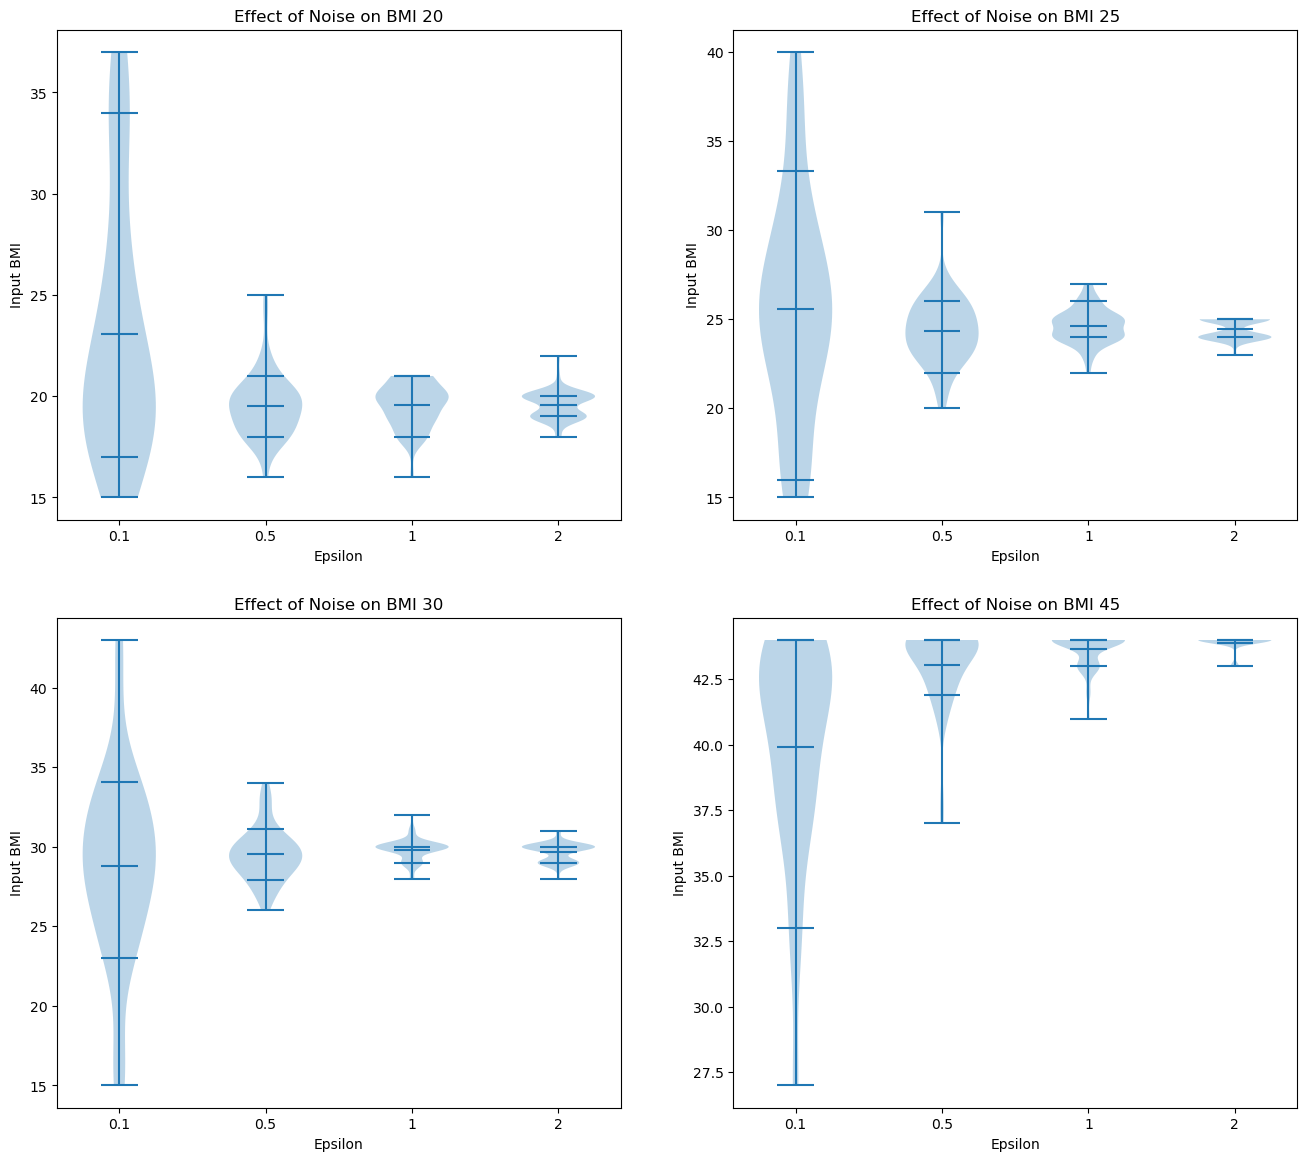

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(bmis):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(bmi_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input BMI")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on BMI %s" % salary)
plt.show()

In [ ]:
# Create a 2 by 2 figure plot
# Data is already cached in datasets/med-qa

"""
Experiment 2: Varying Age and BMI.
"""
output_dataset = np.zeros((num_runs,len(bmis),len(epsilon)))
age_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
bmi_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
bp_sys_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
bp_dia_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))
heart_rate_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))

system_text = "You are a medical assistant that answers questions from a user about their health based on their vitals with either 'Yes' or 'No'. For example, 'User: Jon Smith is a 50 year old man, with bmi 24, blood pressure of 120/80mmHG and heart rate of 60bpm. Is the patient healthy based on their vitals?. Assistant: '"

data_age = {}

for age in ages:
    for i, bmi in tqdm(zip(range(len(bmis)), bmis), total=len(bmis)):
    #     text = f'User: Jon Smith is a {age} year old man, with bmi {bmi}, blood pressure of {bp_sys}/{bp_dia}mmHG and heart rate of {heart_rate}bpm. Is the patient healthy based on their vitals?. Assistant: '                        
        text = f'User: Jon Smith is a {age} year old man, with bmi {bmi}, blood pressure of 120/80mmHG and heart rate of 60bpm. Is the patient healthy based on their vitals?. Assistant: '                        
        entities = extract_entities_regex(text, fields=['age', 'bmi'])

        for j in range(len(epsilon)):
            output_fraction = []
            outputs = []
            inputs = []
            age_inputs = []
            bmi_inputs = []
            bp_sys_inputs = []
            bp_dia_inputs = []
            heart_rate_inputs = []

            for k in range(num_runs):
                encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c,)
                new_text = update_entities_regex(text, encrypted_entities)
                completion = await query_with_retry(new_text,system_text)
                response = completion.choices[0]['message']['content'].replace('.','')
                if response=='Yes': outputs.append(1)
                else: outputs.append(0)
                all_extracted_entities = extract_entities_regex(new_text)
                bmi_inputs.append(float(extract_entities_regex(new_text)['bmi']))
                bp_sys_inputs.append(float(extract_entities_regex(new_text)['bp_sys']))
                bp_dia_inputs.append(float(extract_entities_regex(new_text)['bp_dia']))
                heart_rate_inputs.append(float(extract_entities_regex(new_text)['heart_rate']))
                age_inputs.append(float(extract_entities_regex(new_text)['age']))

            output_dataset[:,i,j] = outputs
            bmi_dataset[:,i,j] = bmi_inputs
            bp_sys_dataset[:,i,j] = bp_sys_inputs
            bp_dia_dataset[:,i,j] = bp_dia_inputs
            heart_rate_dataset[:,i,j] = heart_rate_inputs
            age_dataset[:,i,j] = age_inputs
    
    data_age[age] = [output_dataset, bmi_dataset, bp_sys_dataset, bp_dia_dataset, heart_rate_dataset, age_dataset]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Dump data
# import pickle
# with open('../datasets/med-qa/format_eval_med_data_age_bmi.pkl', 'wb') as fp:
#     pickle.dump(data_age, fp)

In [ ]:
# Load data
import pickle
with open('../datasets/med-qa/format_eval_med_data_age_bmi.pkl', 'rb') as fp:
    data_age = pickle.load(fp)

In [ ]:
import numpy as np
fractions_list = []
salary_list = []
noise_list = []
age_list = []
for z, age in enumerate(ages):
    for j, salary in enumerate(salaries):
        for k, epsilons in enumerate(epsilon):
            for i in range(num_runs):
                fraction_value = experiment_2['fraction_dataset_'+age][i, j, k]
                fractions_list.append(fraction_value)
                salary_list.append(salary)
                noise_list.append(epsilons)
                age_list.append(experiment_2['age_dataset_'+age][i, k])

# Concatenate dataframes for different age groups
data = {'fractions': fractions_list, 'salary': salary_list, 'noise': noise_list, 'age': age_list}
df = pd.DataFrame(data)

X = df[['age', 'salary', 'noise']]
y = df['fractions']

X = sm.add_constant(X)


In [ ]:
# Regression plots
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(age_list, fractions_list, s=10, alpha=0.1, edgecolors="k")
xseq = np.linspace(10, 100, num=100)
ax.plot(xseq, quant_reg.params['const'] + quant_reg.params['age'] * xseq, color="r", lw=2.5);
ax.set_xlabel('Age')  # Label for x-axis
ax.set_ylabel('Output ')
ax.set_title('Logistic Regression of Health against Age')

In [17]:
# vital statistics
# bmis = [20, 25, 30, 45]
heights = [165, 175, 185, 195]
weights = [55, 65, 75, 90]
# bp_systoles = [100, 120, 130, 140]
# bp_diastoles = [60, 80, 90, 100]
# heart_rates = [60, 75, 90, 120]
# ages = [15, 30, 55, 70]

In [18]:
# Create a 2 by 2 figure plot
# Data is already cached in datasets/med-qa

"""
Experiment 3: Varying BMI via height and weight.
"""
output_dataset = np.zeros((num_runs,len(heights),len(epsilon)))
age_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
bmi_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
height_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
weight_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
# heart_rate_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))

system_text = "You are a medical assistant that answers questions from a user about their health based on their vitals with either 'Yes' or 'No'. For example, 'User: Jon Smith is a 30 year old man who has a height of 165cm, weight of 70kg and bmi 25.7. Is the patient healthy based on their vitals?. Assistant: '"
names = ['output', 'bmi', 'age', 'height', 'weight']
data_weight = {weight: {name: np.zeros((num_runs,len(heights),len(epsilon))) for name in names} for weight in weights}

for weight in weights:
    for i, height in tqdm(zip(range(len(heights)), heights), total=len(heights)):
        bmi = (10000*weight)/(height**2)
    #     text = f'User: Jon Smith is a {age} year old man, with bmi {bmi}, blood pressure of {bp_sys}/{bp_dia}mmHG and heart rate of {heart_rate}bpm. Is the patient healthy based on their vitals?. Assistant: '                        
        text = f'User: Jon Smith is a 30 year old man, who has a height of {height}cm, weight of {weight}kg and bmi {bmi:.2f}. Is the patient healthy based on their vitals?. Assistant: '                        
        entities = extract_entities_regex(text, fields=['height', 'weight'])

        for j in range(len(epsilon)):
            output_fraction = []
            outputs = []
            inputs = []
            age_inputs = []
            bmi_inputs = []
            height_inputs = []
            weight_inputs = []
            heart_rate_inputs = []

            for k in range(num_runs):
                encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c,)
                new_bmi = (10000*encrypted_entities['weight'])/(encrypted_entities['height']**2)
                encrypted_entities['bmi'] = new_bmi
                new_text = update_entities_regex(text, encrypted_entities)
                completion = await query_with_retry(new_text,system_text)
                response = completion.choices[0]['message']['content'].replace('.','')
                if response=='Yes': outputs.append(1)
                else: outputs.append(0)
                all_extracted_entities = extract_entities_regex(new_text, fields=['age', 'bmi', 'height', 'weight'])
                bmi_inputs.append(float(all_extracted_entities['bmi']))
                height_inputs.append(float(all_extracted_entities['height']))
                weight_inputs.append(float(all_extracted_entities['weight']))
                age_inputs.append(float(all_extracted_entities['age']))

            data_weight[weight]['output'][:,i,j] = outputs
            data_weight[weight]['bmi'][:,i,j] = bmi_inputs
            data_weight[weight]['height'][:,i,j] = height_inputs
            data_weight[weight]['weight'][:,i,j] = weight_inputs
            data_weight[weight]['age'][:,i,j] = age_inputs

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:18:42 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '1305', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:21:05 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '2070', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:24:28 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '2067', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:25:23 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '206', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x-

In [19]:
# Dump data
# import pickle
# with open('../datasets/med-qa/format_eval_med_data_ht_wt_bmi.pkl', 'wb') as fp:
#     pickle.dump(data_weight, fp)

In [27]:
# Load data
import pickle
with open('../datasets/med-qa/format_eval_med_data_ht_wt_bmi.pkl', 'rb') as fp:
    data_weight = pickle.load(fp)

In [28]:
merged_heights = np.concatenate([data_weight[55]['height'], 
                                 data_weight[65]['height'], 
                                 data_weight[75]['height'], 
                                 data_weight[90]['height']], axis=0)
merged_heights.shape

(200, 4, 4)

In [41]:
merged_bmi = np.concatenate([data_weight[55]['bmi'], 
                                 data_weight[65]['bmi'], 
                                 data_weight[75]['bmi'], 
                                 data_weight[90]['bmi']], axis=0)
merged_bmi.shape

(200, 4, 4)

In [30]:
data_weight[55]['height'].shape

(50, 4, 4)

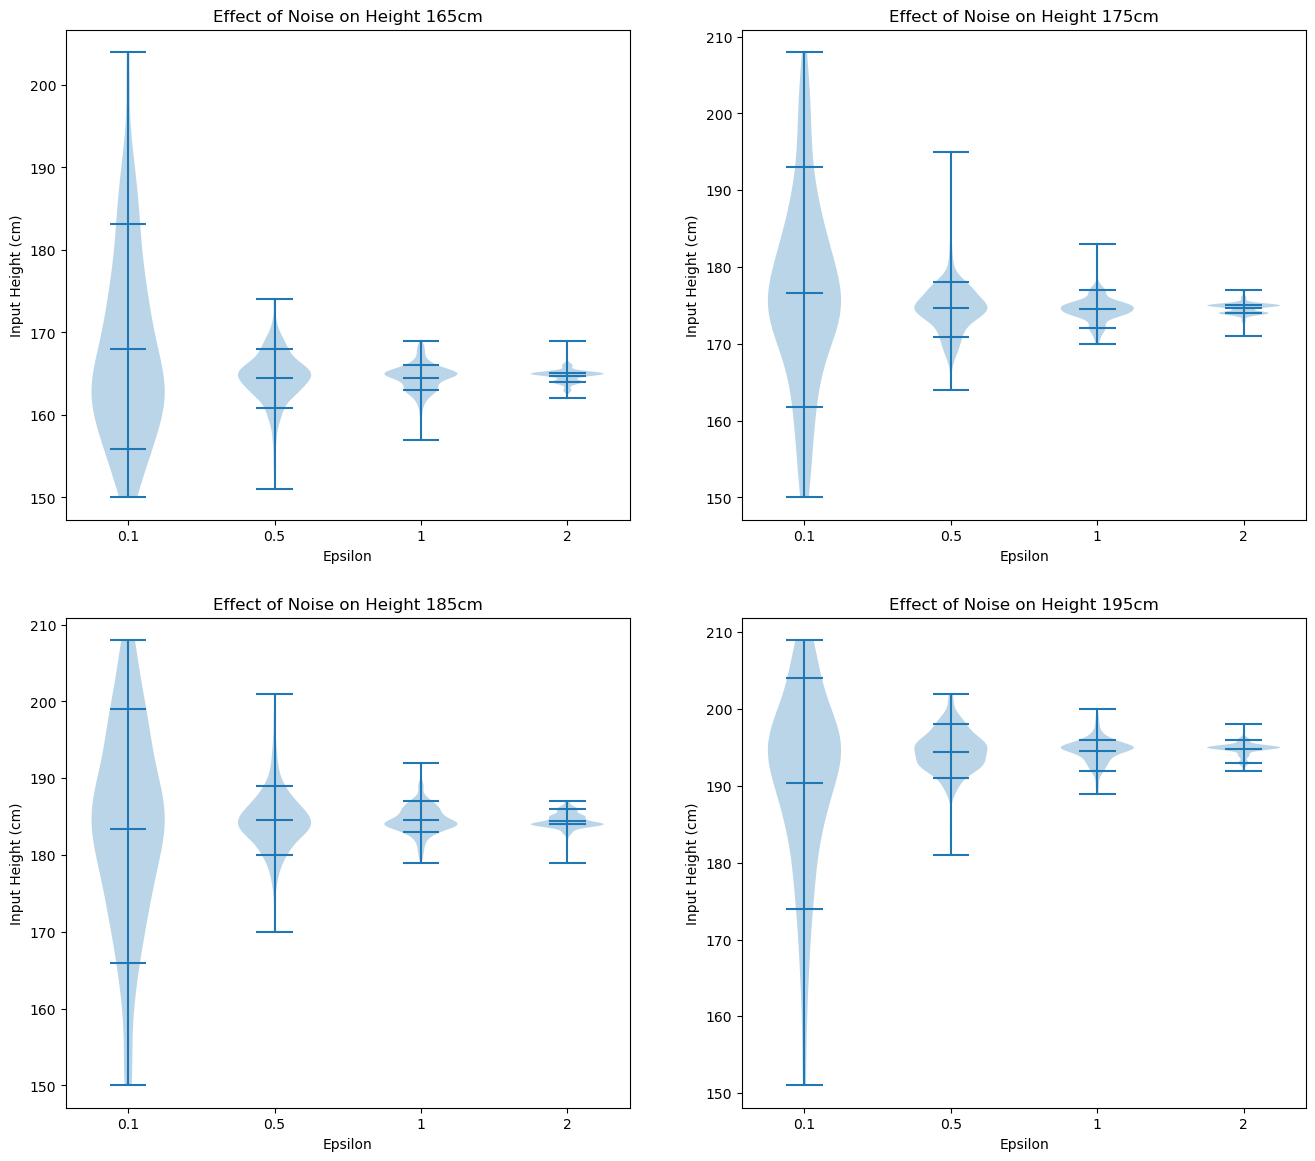

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(heights):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(merged_heights[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Height (cm)")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Height %scm" % salary)
plt.savefig('medqa_height_noise_violin.png')
plt.show()

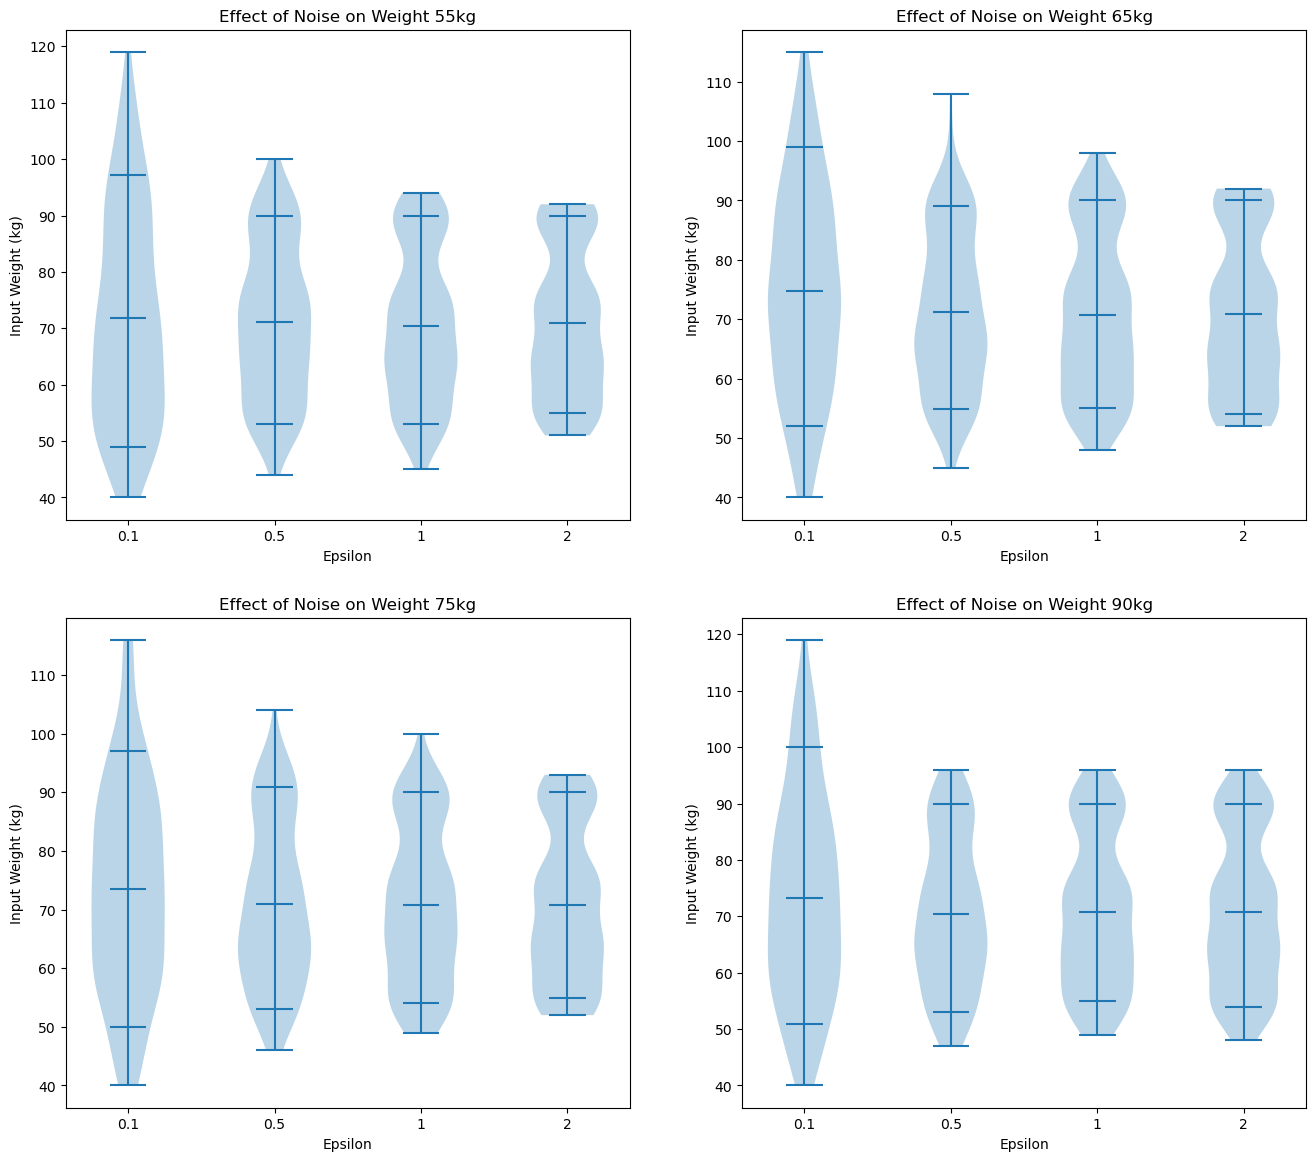

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(weights):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(merged_weights[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Weight (kg)")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Weight %skg" % salary)
plt.savefig('medqa_weight_noise_violin.png')
plt.show()

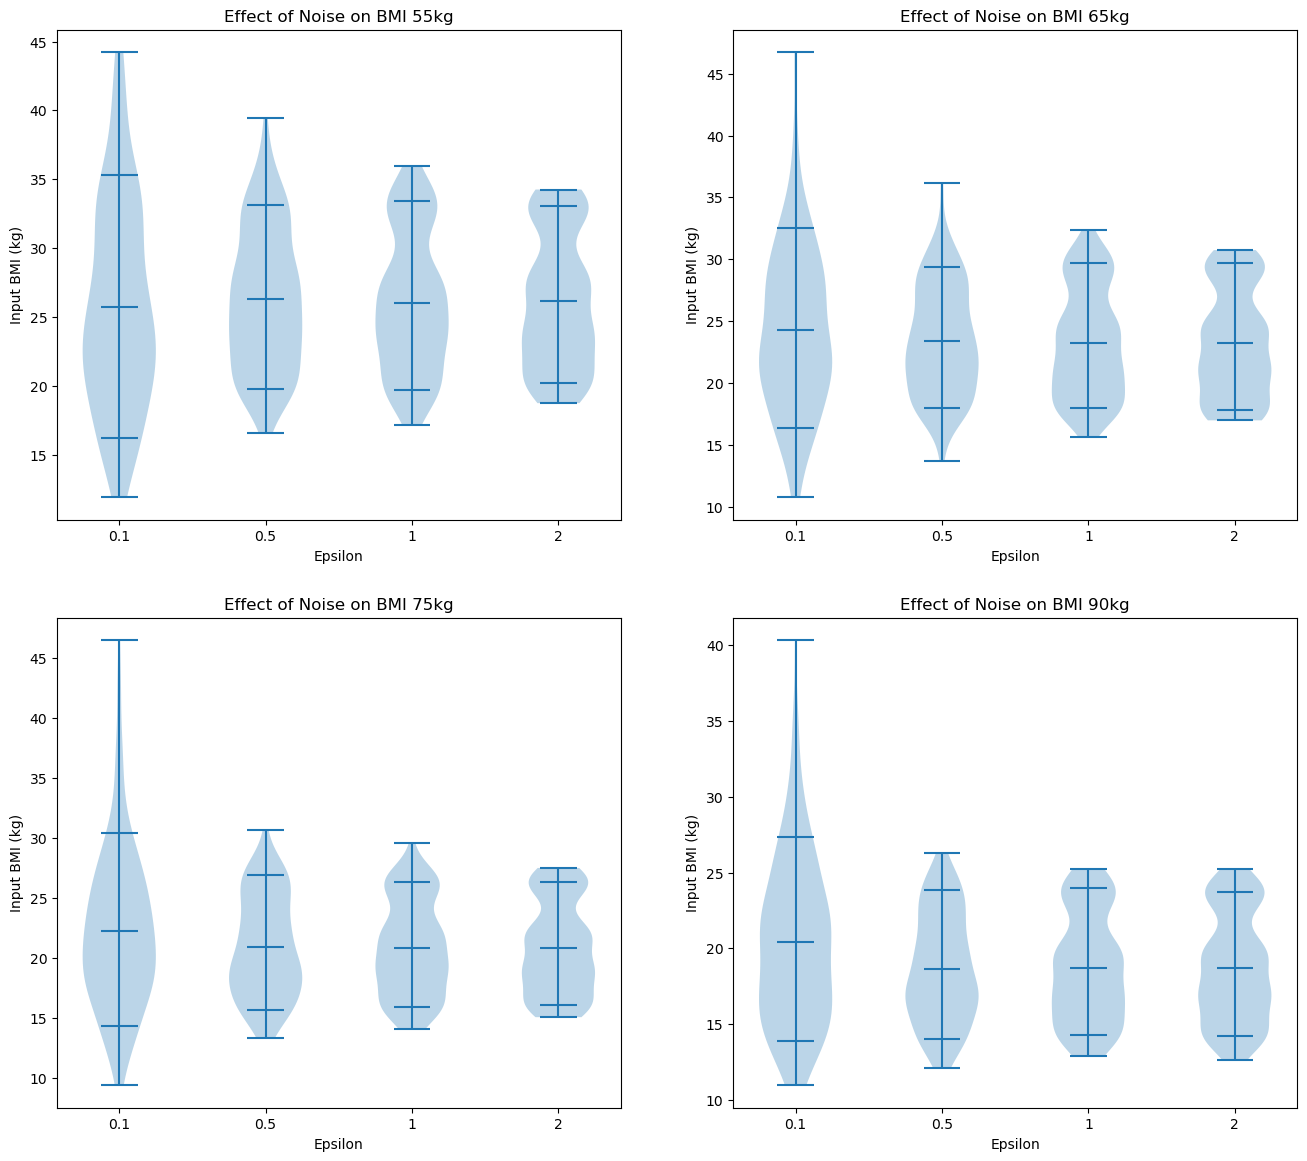

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(weights):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(merged_bmi[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input BMI (kg)")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on BMI %skg" % salary)
plt.savefig('medqa_bmi_noise_violin.png')
plt.show()

In [ ]:
import numpy as np
output_list = []
height_list = []
noise_list = []
weight_list = []
bmi_list = []
bmi_list_squared = []
for z, weight in enumerate(weights):
    for j, height in enumerate(heights):
        for k, epsilons in enumerate(epsilon):
            for i in range(num_runs):
                output = data_weight[weight]['output'][i, j, k]
                output_list.append(output)
                height_list.append(data_weight[weight]['height'][i, j, k])
                weight_list.append(data_weight[weight]['weight'][i, j, k])
#                 height_list.append(height)
#                 weight_list.append(weight)
                bmi_list.append(data_weight[weight]['bmi'][i, j, k])
                bmi_list_squared.append(data_weight[weight]['bmi'][i, j, k]**2)
                noise_list.append(epsilons)

# Concatenate dataframes for different age groups
data = {'health': output_list, 'bmi_squared': bmi_list_squared, 'bmi': bmi_list, 'height': height_list, 'noise': noise_list, 'weight': weight_list}
df = pd.DataFrame(data)

X = df[['bmi', 'bmi_squared', 'noise', 'height', 'weight']]
y = df['health']

X = sm.add_constant(X)

# Perform logistic regression
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())
print('\n')

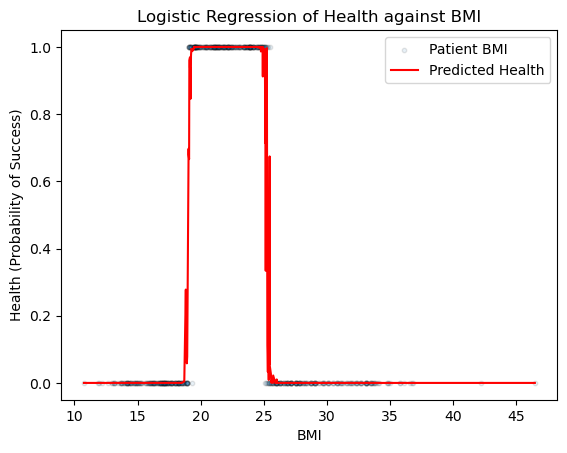

In [45]:
# Get the predicted probabilities
result = log_reg
probs = result.predict(X)

# Sort the data for plotting
sorted_indices = np.argsort(bmi_list)
X_sorted = np.asarray(bmi_list)
X_sorted = X_sorted[sorted_indices]
probs_sorted = probs[sorted_indices]
# probs_sorted = probs
# Plot the logistic regression curve
plt.scatter(bmi_list, output_list, s=10, alpha=0.1, edgecolors="k", label='Patient BMI')
plt.plot(X_sorted, probs_sorted, color='red', label='Predicted Health')
plt.xlabel('BMI')
plt.ylabel('Health (Probability of Success)')
plt.title('Logistic Regression of Health against BMI')
plt.legend()
plt.savefig('medqa_logistic_regression_bmi.png')
plt.show()